In this notebook, we present the preprocessing steps of E data

In [1]:
import h5py
from functools import reduce
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cplAE_MET.utils.analysis_helpers as proc_utils
from cplAE_MET.preproc.data_proc_E import set_paths

# This is used to be able to run the notebook both remote and locally
Allen_dir = "/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/git_workspace/cplAE_MET/data/"
remote_dir = "/Users/fahimehb/Documents/git-workspace/cplAE_MET/data/"

/home/fahimehb/miniconda3/envs/cplae_met/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read the config file to set the paths

In [2]:
pth = set_paths(config_file='config_preproc.toml')

In [3]:
pth.keys()

dict_keys(['package_dir', 'data_dir', 'specimen_ids_file', 'gene_file', 't_data_output_file', 't_anno_output_file', 'gene_id_output_file', 'm_data_folder', 'm_anno', 'hist2d_120x4_folder', 'arbor_density_file', 'ivscc_inh_m_features', 'ivscc_exc_m_features', 'fmost_exc_m_features', 'm_output_file', 'arbor_density_PC_vars_file', 'E_timeseries_file', 'ipfx_features_file', 'e_output_file', 'met_output_file', 'config_file', 'input', 'specimen_ids', 'E_timeseries', 'ipfx_features', 'e_output'])

In [4]:
ids = pd.read_csv(pth['specimen_ids'])
specimen_ids = ids['specimen_id'].tolist()
print("...................................................")
print("There are", len(specimen_ids), "sample_ids in the dataset")

...................................................
There are 8643 sample_ids in the dataset


In [5]:
print("...................................................")
print("Loading E data time series")
hf = h5py.File(pth['E_timeseries'], 'r')

h5_ids = [str(i) for i in np.array(hf.get("ids"))]
print("Number of cells in h5(time series file):", len(h5_ids))

print("...................................................")
print(len([i for i in specimen_ids if i not in h5_ids]), "cells do not have time series data!")

print("...................................................")
print("keeping only ids that are inside specimen id list")
mask_h5_ids = [True if i in specimen_ids else False for i in h5_ids]
h5_ids = np.array(h5_ids)[mask_h5_ids]
print("In total remains this amount of cells:", sum(mask_h5_ids))

#Read time series into a dictionary and masking them for only the ids that exist in the dataset
time_series = {}
for k in hf.keys():
    time_series[k] = np.array(hf.get(k))[mask_h5_ids]


...................................................
Loading E data time series
Number of cells in h5(time series file): 7838
...................................................
805 cells do not have time series data!
...................................................
keeping only ids that are inside specimen id list
In total remains this amount of cells: 7838


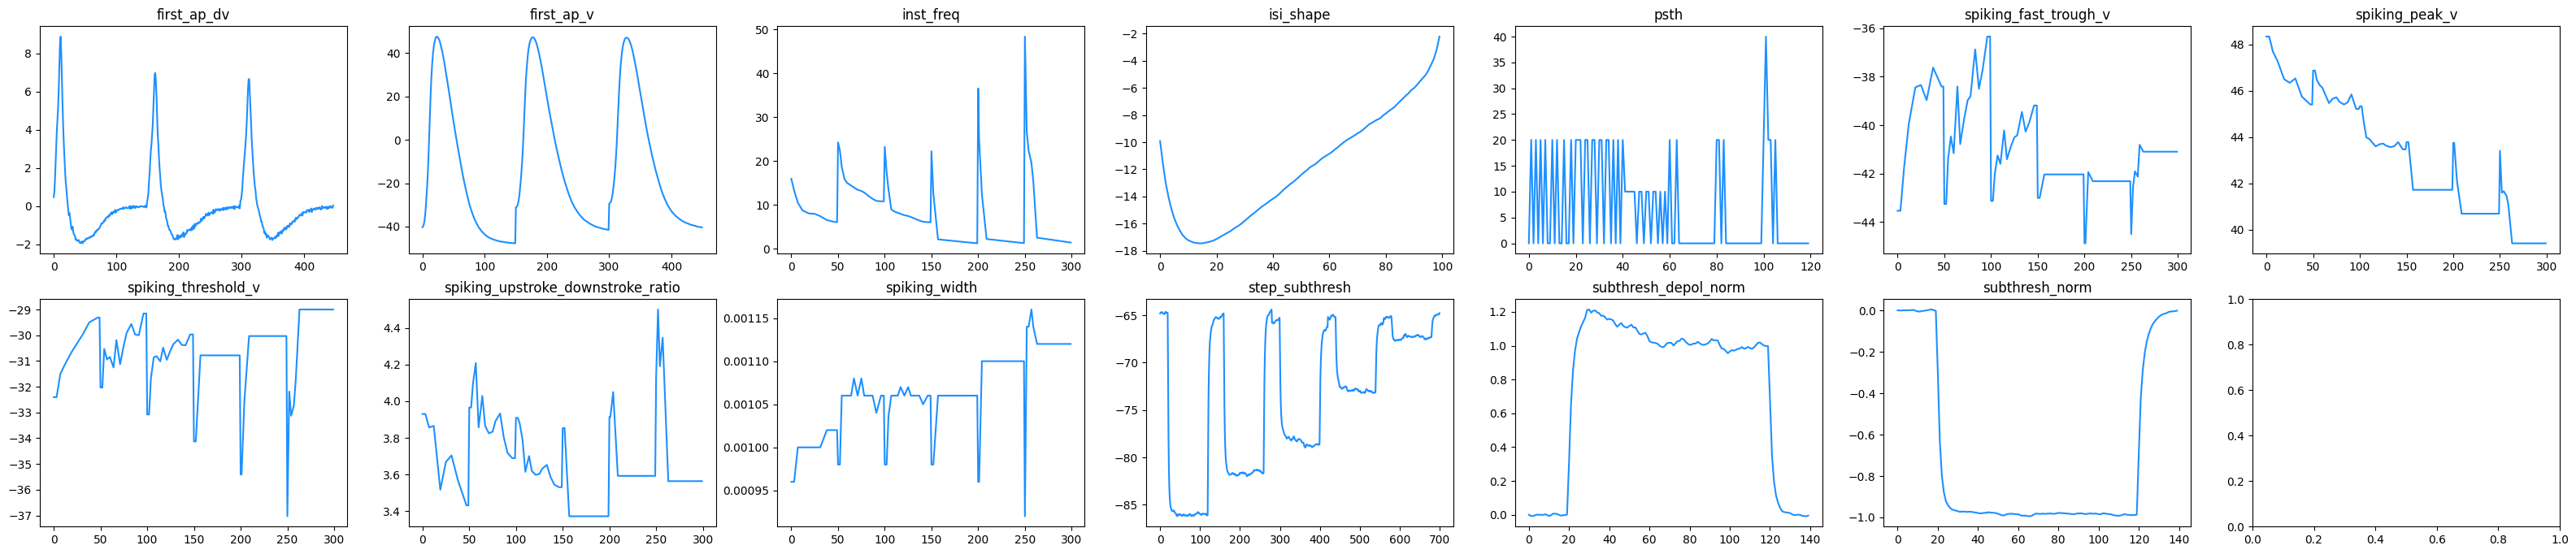

In [6]:
# plot all the timeseries for one random cell
cellid = 130
fig, axs = plt.subplots(2,7, figsize=(40, 8))
exp = [i for i in time_series.keys() if i!="ids"]

for ax, sub_expt in zip(axs.flatten(), exp):
    ax.plot(time_series[sub_expt][cellid,:], color='dodgerblue')
    ax.set_title(sub_expt)

In [7]:
fig.savefig("/home/fahimehb/Local/new_codes/cplAE_MET/data/results/Figure/E_timeseries.pdf")

Before applying PCA, we are going to remove all the cells that have nan values. For this, we do it per experiment, meaning that cells will be removed for only the experiment that has nan

In [8]:
print("...................................................")
print("removing nan values from individual experiments")
# Check if there is any nan values in any of the np arrays
expt_with_nans = []
for sub_expt in time_series.keys():
    if sub_expt != "ids":
        if np.isnan(time_series[sub_expt]).any():
            print("nan values were detected in this experiment:", sub_expt)
            expt_with_nans.append(sub_expt)

# Remove nan values from the timeseries with nan
dropped_cells = {}
for sub_expt in expt_with_nans:
    time_series[sub_expt], dropped_cells[sub_expt] = \
        proc_utils.drop_nan_rows_or_cols(time_series[sub_expt], 1)

...................................................
removing nan values from individual experiments
nan values were detected in this experiment: subthresh_depol_norm


In [9]:
# Check the size of each timeseris to see for which experiment the nans were removed
for sub_expt in time_series.keys():
    if sub_expt != "ids":
        print(sub_expt, time_series[sub_expt].shape)

first_ap_dv (7838, 447)
first_ap_v (7838, 450)
inst_freq (7838, 300)
isi_shape (7838, 100)
psth (7838, 120)
spiking_fast_trough_v (7838, 300)
spiking_peak_v (7838, 300)
spiking_threshold_v (7838, 300)
spiking_upstroke_downstroke_ratio (7838, 300)
spiking_width (7838, 300)
step_subthresh (7838, 700)
subthresh_depol_norm (7183, 140)
subthresh_norm (7838, 140)


As it is clear, only for one of the experiment the nans were removed and therefore the size if 5214 instead of 5854.

# Applying PCA

We compute number of components that can explain more than 97% of the variance in the data:

...................................................
PCA analysis
first_ap_dv


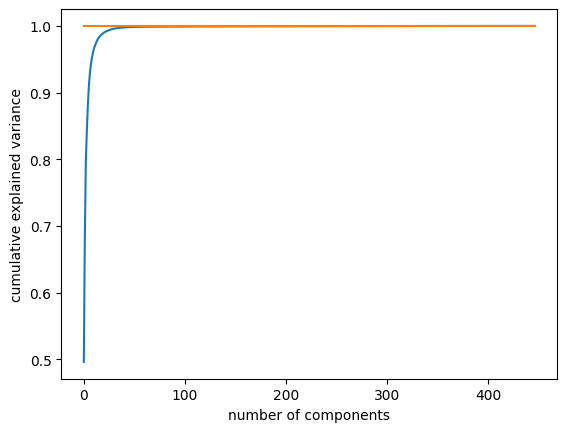

first_ap_v


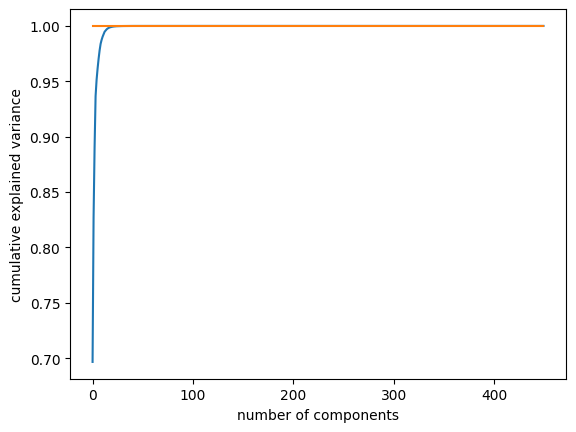

inst_freq


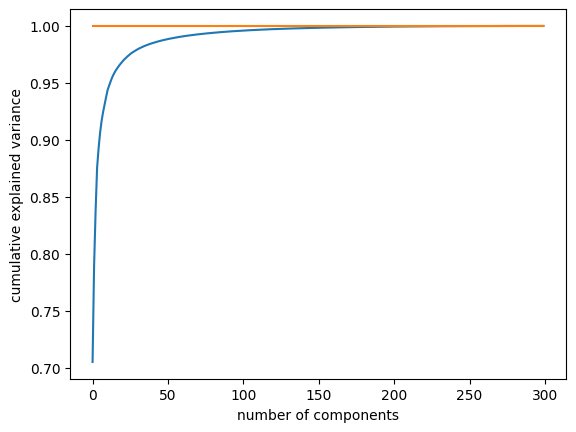

isi_shape


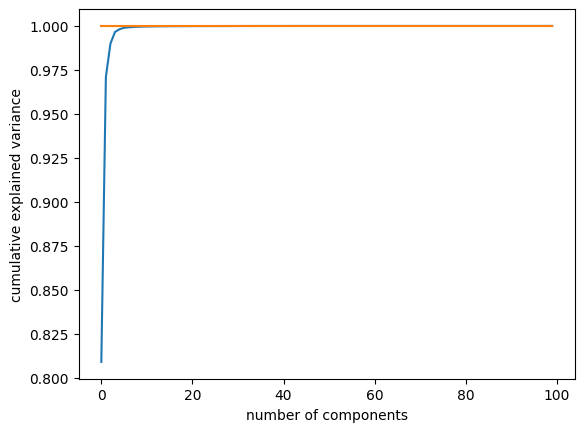

psth


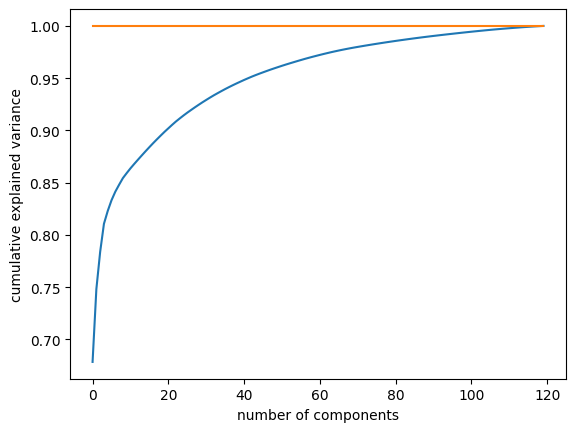

spiking_fast_trough_v


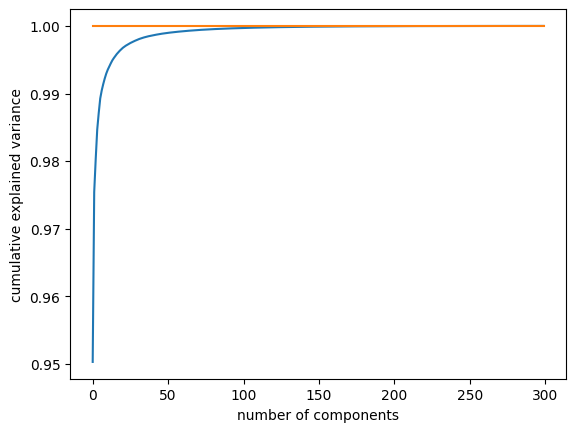

spiking_peak_v


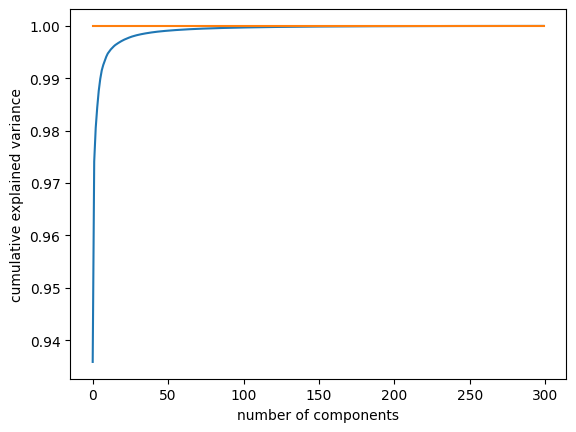

spiking_threshold_v


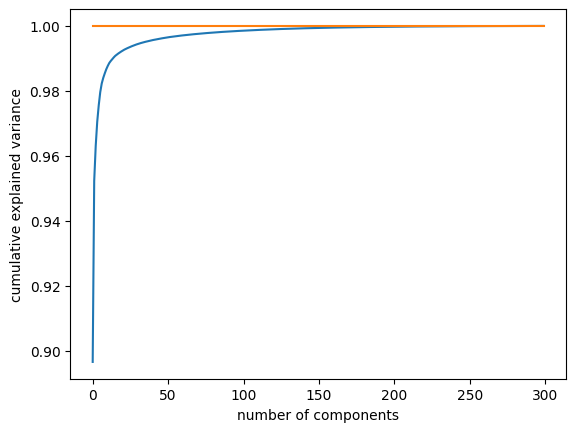

spiking_upstroke_downstroke_ratio


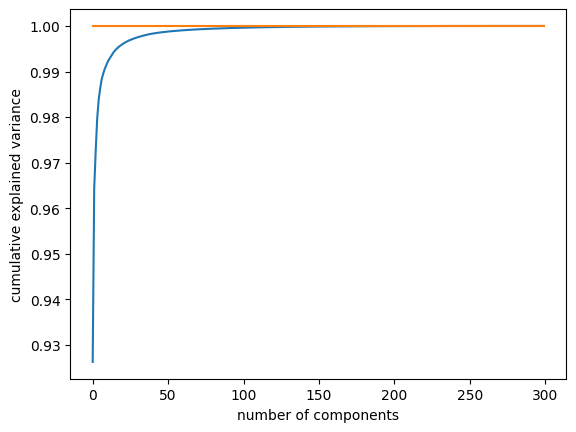

spiking_width


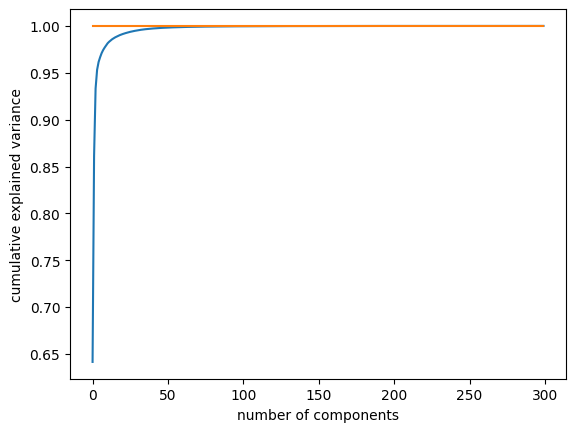

step_subthresh


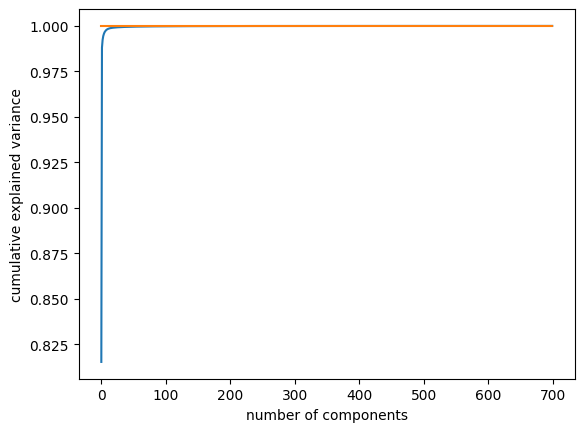

subthresh_depol_norm


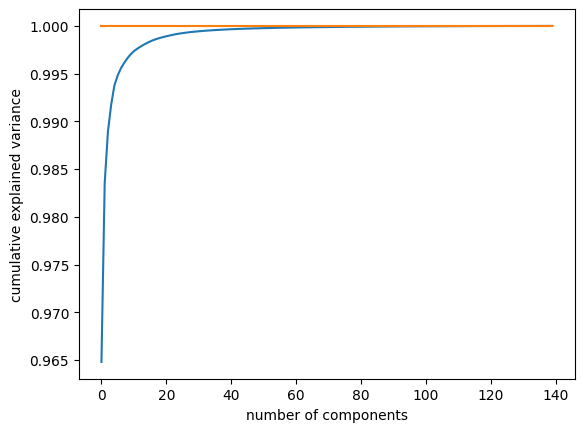

subthresh_norm


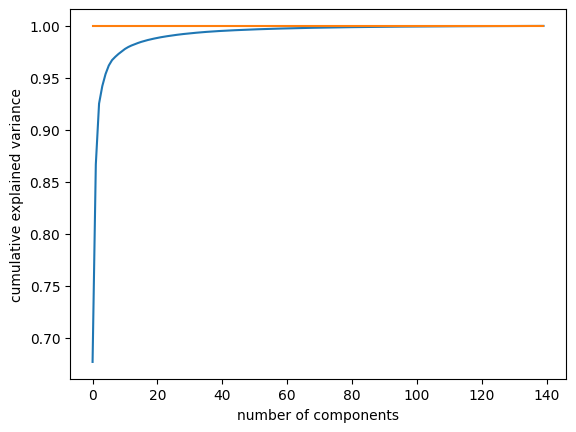

In [10]:
print("...................................................")
print("PCA analysis")
# Apply PCA and keep the n components as computed below
number_of_components = {}
for k in hf.keys():
    if k not in ["ids"]:
        print(k)
        n_comp_at_thr = proc_utils.get_PCA_explained_variance_ratio_at_thr(
            nparray=time_series[k], threshold=0.97)
        #If number of components are zero, then use 1
        if n_comp_at_thr == 0:
                number_of_components[k] = 1
        if n_comp_at_thr > 10:
                number_of_components[k] = 10
        else:
                number_of_components[k] = n_comp_at_thr

How many features in each experiment is required to explain at least 97% of the variance in the data?

In [11]:
PC = {}
for k in hf.keys():
    if k != "ids":
        pca = PCA(number_of_components[k])
        PC[k] = pca.fit_transform(time_series[k])
        print(k, PC[k].shape)

first_ap_dv (7838, 10)
first_ap_v (7838, 6)
inst_freq (7838, 10)
isi_shape (7838, 1)
psth (7838, 10)
spiking_fast_trough_v (7838, 1)
spiking_peak_v (7838, 1)
spiking_threshold_v (7838, 3)
spiking_upstroke_downstroke_ratio (7838, 2)
spiking_width (7838, 6)
step_subthresh (7838, 1)
subthresh_depol_norm (7183, 1)
subthresh_norm (7838, 7)


# Scaling PC features

In [31]:
print("...................................................")
print("Scaling PCA features")
#Scaling PC features
Scaled_PCs = {}
total_var = {}

for k in PC.keys():
    total_var[k] = np.sqrt(np.sum(pd.DataFrame(PC[k]).var(axis=0)))
    Scaled_PCs[k] = PC[k] / total_var[k]
    if (proc_utils.check_for_nan(Scaled_PCs[k])):
        Scaled_PCs[k], _ = proc_utils.drop_nan_rows_or_cols(Scaled_PCs[k], axis=1)

...................................................
Scaling PCA features


In [32]:
for k in hf.keys():
    if k != "ids":
        print(k, Scaled_PCs[k].shape)

first_ap_dv (7838, 10)
first_ap_v (7838, 6)
inst_freq (7838, 10)
isi_shape (7838, 1)
psth (7838, 10)
spiking_fast_trough_v (7838, 1)
spiking_peak_v (7838, 1)
spiking_threshold_v (7838, 3)
spiking_upstroke_downstroke_ratio (7838, 2)
spiking_width (7838, 6)
step_subthresh (7838, 1)
subthresh_depol_norm (7183, 1)
subthresh_norm (7838, 7)


### Outliers within 6 std going to be removed from scaled PCs

In [33]:
print("...................................................")
print("Removing outliers whithin 6 std from scaled PCs")
#attaching specimen ids and removing outliers
for k in PC.keys():
    Scaled_PCs[k] = pd.DataFrame(Scaled_PCs[k])
    scaling_thr = np.abs(np.max(Scaled_PCs[k].std(axis=0, skipna=True, numeric_only=True)) * 6)
    Scaled_PCs[k] = Scaled_PCs[k][(Scaled_PCs[k] < scaling_thr) & (Scaled_PCs[k] > -1 * scaling_thr)]
    Scaled_PCs[k].columns = [k + "_" + str(i) for i in range(Scaled_PCs[k].shape[1])]
    if k not in dropped_cells.keys():
        Scaled_PCs[k]["specimen_id"] = h5_ids
    else:
        Scaled_PCs[k]["specimen_id"] = np.delete(h5_ids, obj=dropped_cells[k])

    Scaled_PCs[k]['specimen_id'] = Scaled_PCs[k]['specimen_id'].astype(str)

...................................................
Removing outliers whithin 6 std from scaled PCs


### Compare PCs and Scaled_PCs

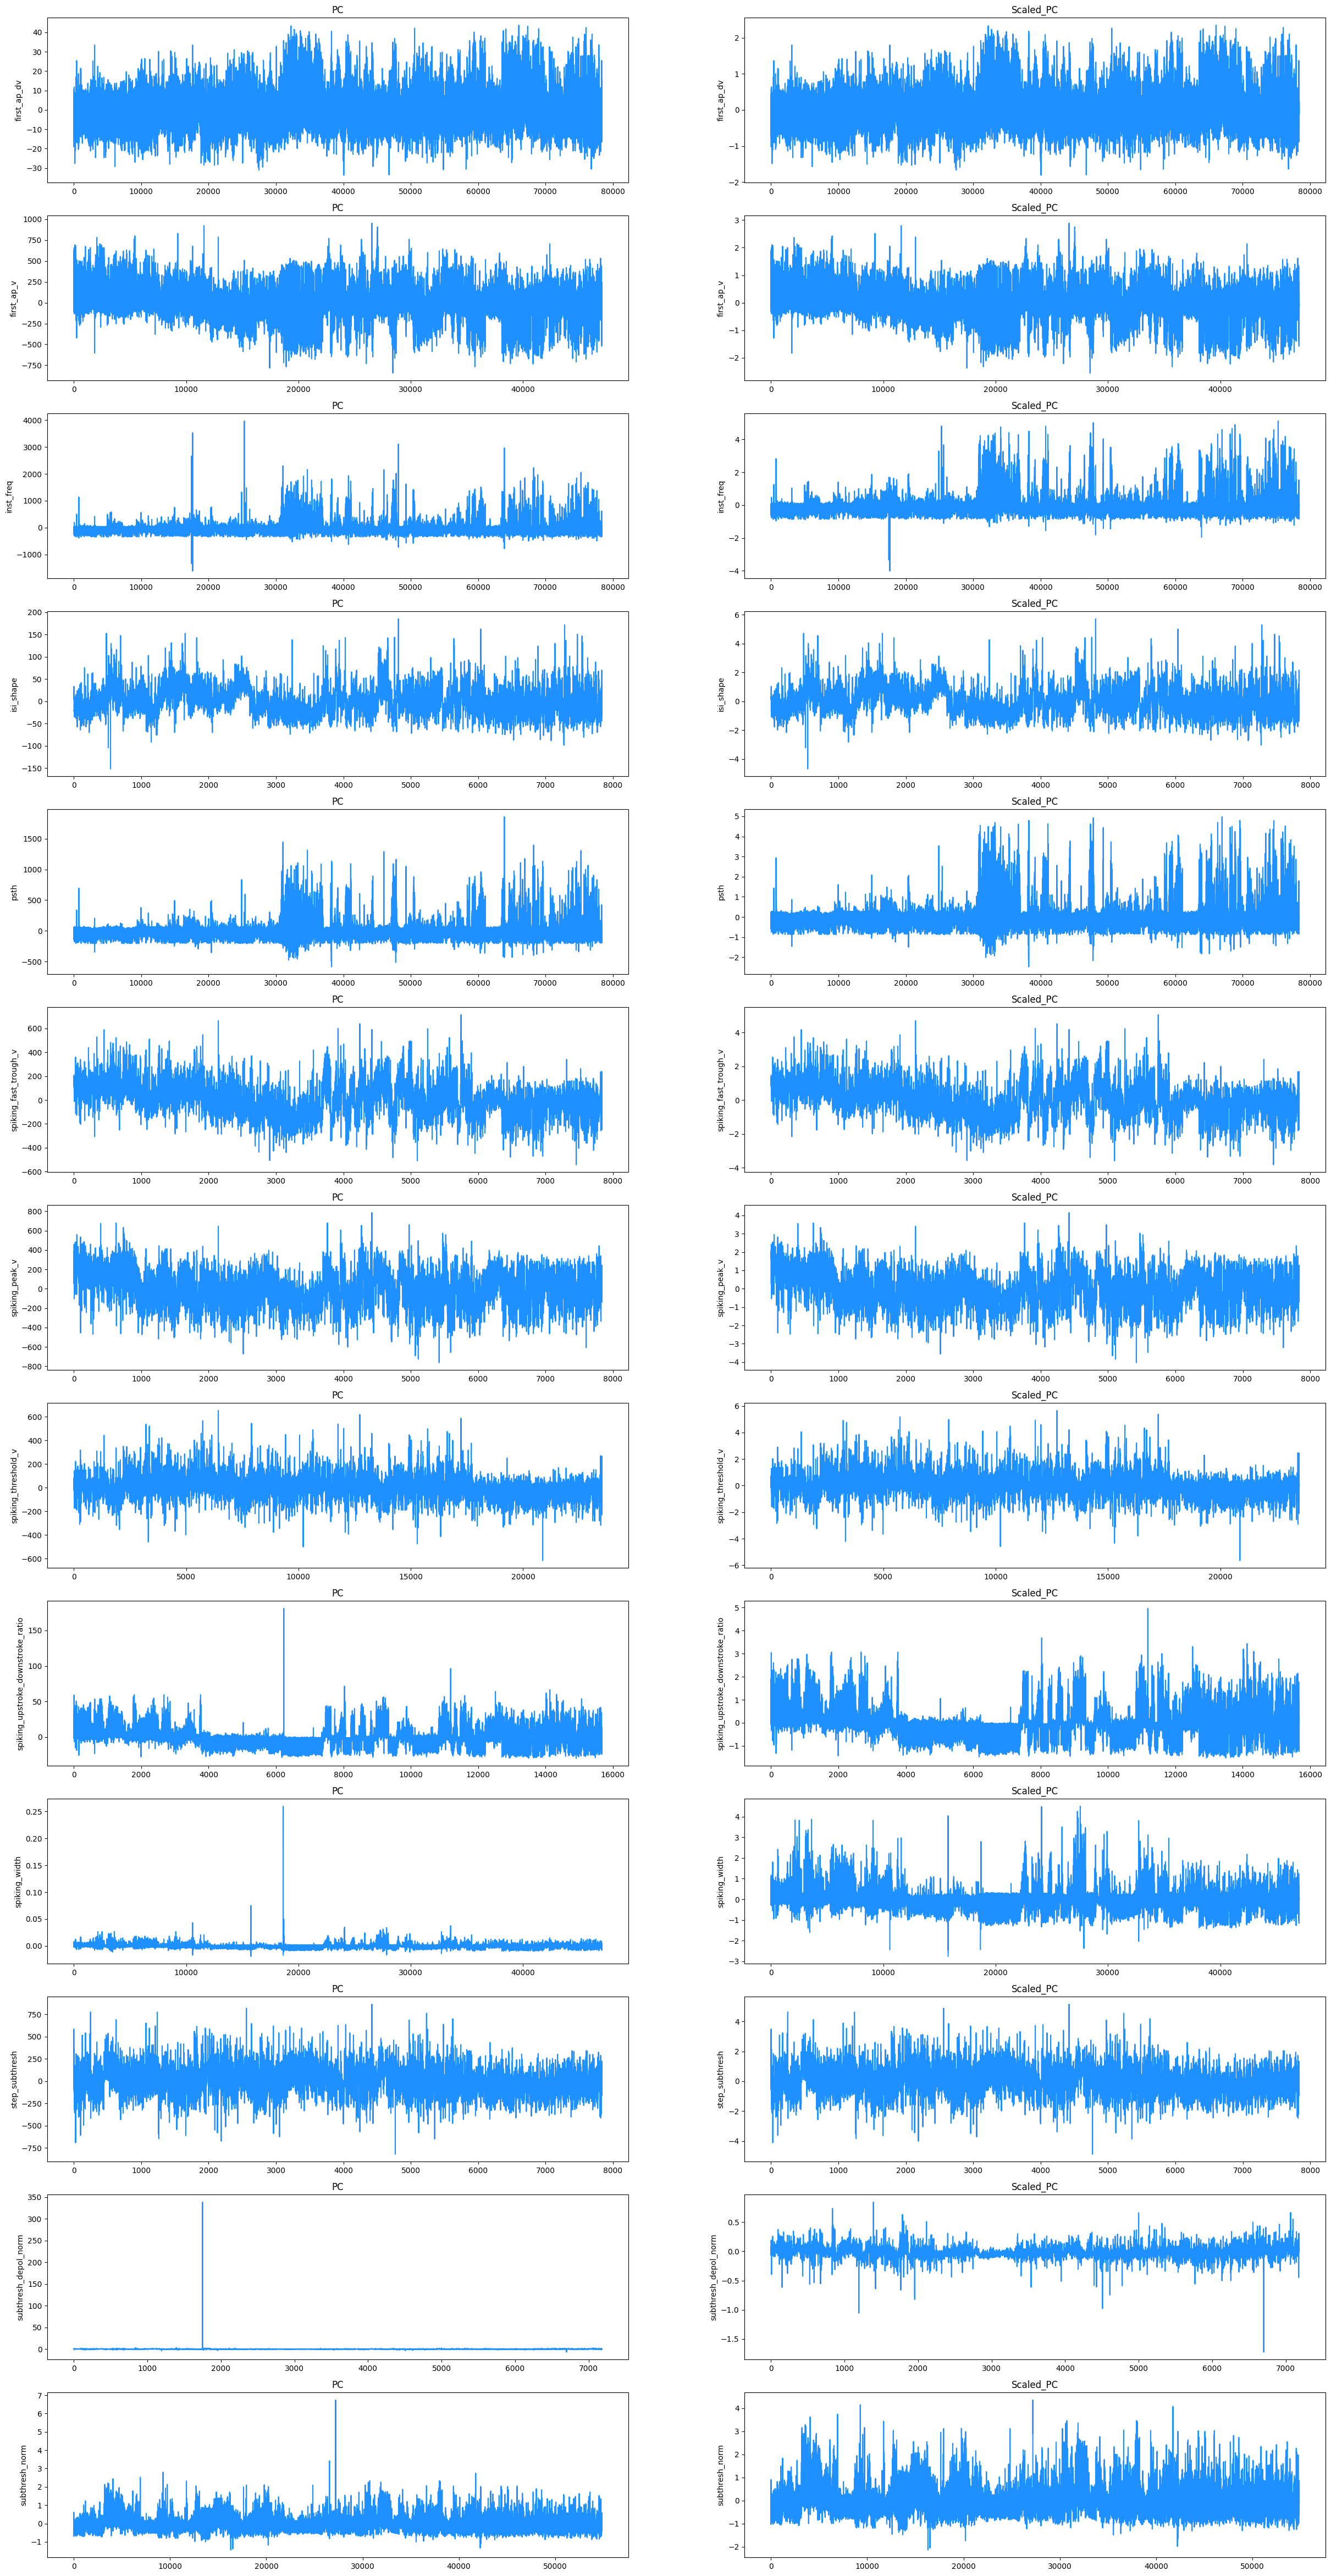

In [34]:
fig, axs = plt.subplots(13,2, figsize=(30, 60))
i = 0
for sub_expt in time_series.keys():
    if sub_expt != "ids":
        axs[i][0].plot(PC[sub_expt].flatten(), color='dodgerblue')
        axs[i][1].plot(np.array(Scaled_PCs[sub_expt].set_index("specimen_id")).flatten(), color='dodgerblue')
        axs[i][0].set_title("PC")
        axs[i][1].set_title("Scaled_PC")
        axs[i][0].set_ylabel(sub_expt)
        axs[i][1].set_ylabel(sub_expt)
        plt.plot()
        i += 1

### Put all the scaled PCs together and plot

Zero-mean the scaled PCs
...................................................


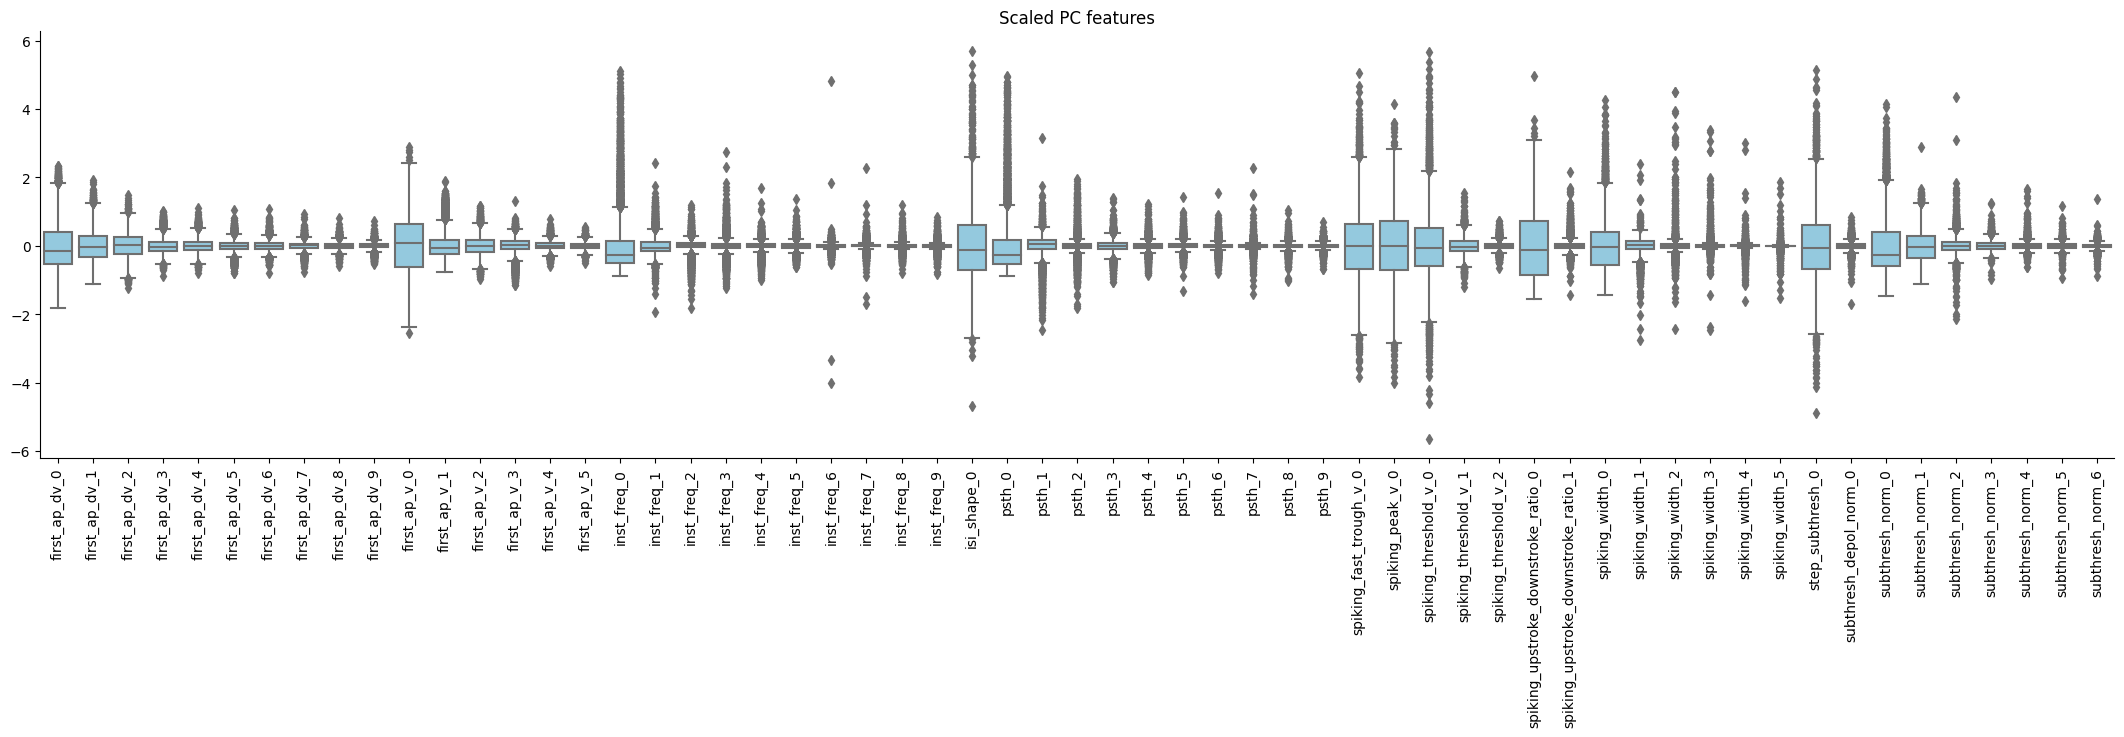

In [47]:
#Merge all scaled PC features into one df
data_frames = []
for k in Scaled_PCs.keys():
    data_frames.append(Scaled_PCs[k])

Scaled_PCs = reduce(lambda left, right: pd.merge(left, right, on=['specimen_id'], how='outer'), data_frames)
print("Zero-mean the scaled PCs")
print("...................................................")
subset_Scaled_PCs = Scaled_PCs[[c for c in Scaled_PCs.columns if c != "specimen_id"]]
subset_Scaled_PCs = (subset_Scaled_PCs - subset_Scaled_PCs.mean(axis=0)) 
subset_Scaled_PCs['specimen_id'] = Scaled_PCs['specimen_id']
Scaled_PCs = subset_Scaled_PCs
df = Scaled_PCs.melt(value_vars=Scaled_PCs[[c for c in Scaled_PCs.columns if c != "specimen_id"]])
sns.catplot(x="variable", y="value", kind='box', data=df, palette=sns.color_palette(["skyblue"]), aspect=4.4)
ax = plt.gca()
ax.set(**{'title': 'Scaled PC features', 'xlabel': '', 'ylabel': ''})
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [46]:
subset_Scaled_PCs.mean(axis=0)

first_ap_dv_0                         -6.084413e-17
first_ap_dv_1                         -2.148065e-17
first_ap_dv_2                          9.433638e-18
first_ap_dv_3                         -1.416462e-20
first_ap_dv_4                         -1.699755e-18
first_ap_dv_5                          9.986058e-19
first_ap_dv_6                          9.029946e-19
first_ap_dv_7                          8.250892e-19
first_ap_dv_8                          6.697431e-18
first_ap_dv_9                          1.372198e-18
first_ap_v_0                           3.206870e-17
first_ap_v_1                           1.317310e-18
first_ap_v_2                           1.185402e-17
first_ap_v_3                           9.674436e-18
first_ap_v_4                          -1.574398e-17
first_ap_v_5                           1.101742e-18
inst_freq_0                            3.210745e-17
inst_freq_1                            9.394740e-18
inst_freq_2                           -3.639930e-17
inst_freq_3 

So far we took care of the timeseries. We now should add other ipfx features to the E data

### IPFX features

...................................................
Loading ipfx features


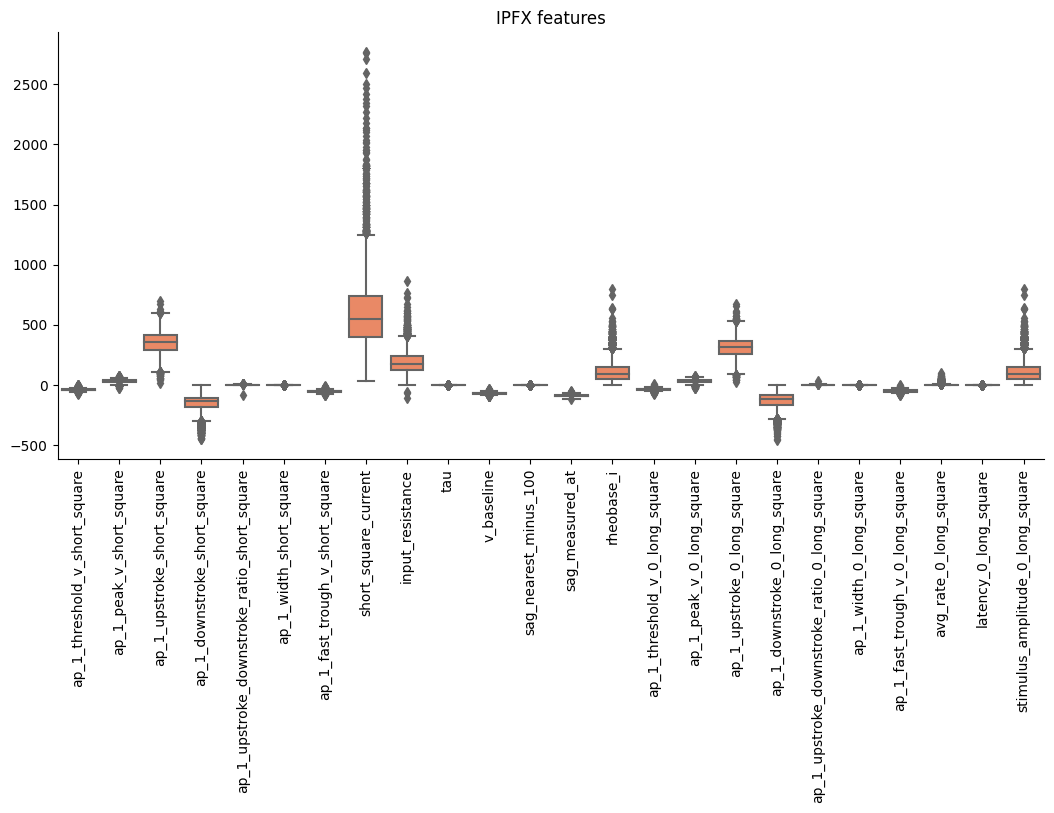

In [17]:
print("...................................................")
print("Loading ipfx features")
ipfx = pd.read_csv(pth['ipfx_features'])

# Rohan used and suggested to use these features
keep_ipfx_features_bioarxiv = ['ap_1_threshold_v_short_square', 'ap_1_peak_v_short_square', 'ap_1_upstroke_short_square', 'ap_1_downstroke_short_square',
'ap_1_upstroke_downstroke_ratio_short_square', 'ap_1_width_short_square', 'ap_1_fast_trough_v_short_square', 'short_square_current', 'input_resistance', 
'tau', 'v_baseline', 'sag_nearest_minus_100', 'sag_measured_at', 'rheobase_i', 'ap_1_threshold_v_0_long_square', 'ap_1_peak_v_0_long_square', 
'ap_1_upstroke_0_long_square', 'ap_1_downstroke_0_long_square', 'ap_1_upstroke_downstroke_ratio_0_long_square', 'ap_1_width_0_long_square', 
'ap_1_fast_trough_v_0_long_square', 'avg_rate_0_long_square', 'latency_0_long_square', 'stimulus_amplitude_0_long_square', "specimen_id"]

ipfx = ipfx[keep_ipfx_features_bioarxiv]

df = ipfx.melt(value_vars=ipfx[[c for c in ipfx.columns if c != "specimen_id"]])
sns.catplot(x="variable", y="value",kind='box', data=df, palette=sns.color_palette(["coral"]),aspect=2.4)
ax = plt.gca()
ax.set(**{'title':'IPFX features','xlabel':'','ylabel':''})
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()


### Zscoring IPFX features

...................................................
Zscoring ipfx features
Removing extreme ipfx values (within 6 std)


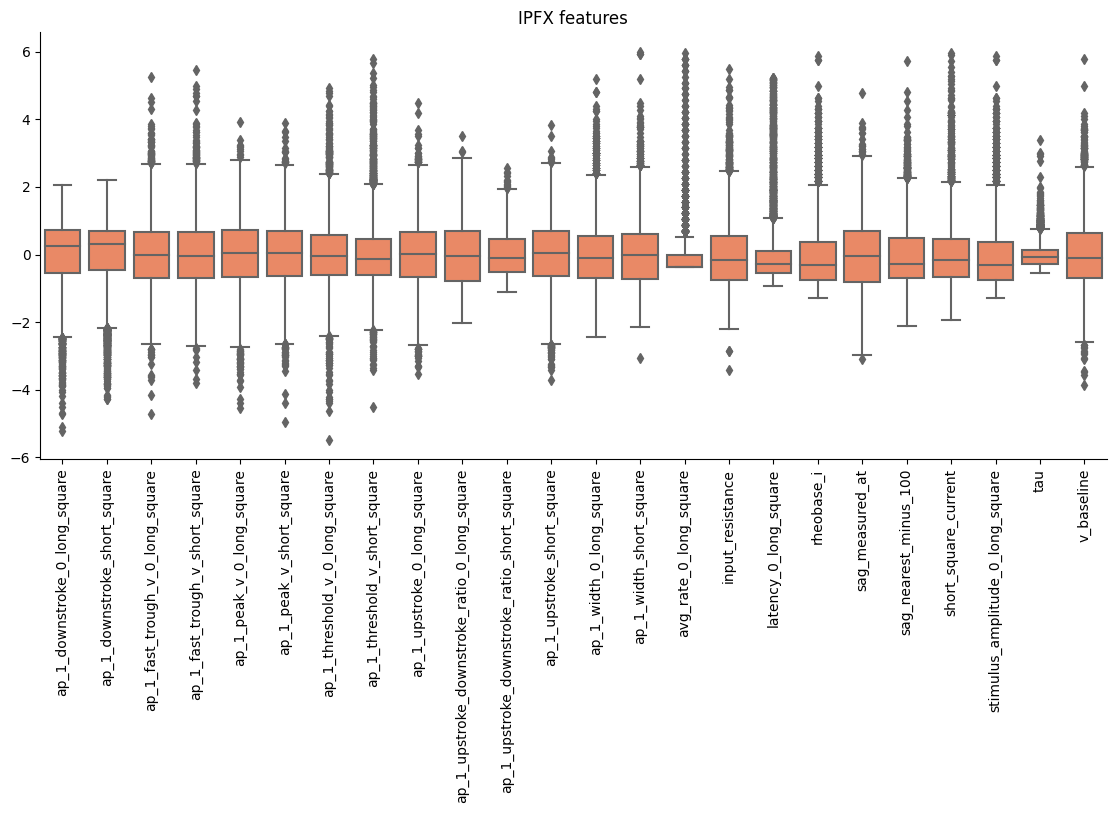

ipfx features size: (6525, 25)


In [18]:
print("...................................................")
print("Zscoring ipfx features")
subset_ipfx = ipfx[[c for c in ipfx.columns if c != "specimen_id"]]
ipfx_norm = (subset_ipfx - subset_ipfx.mean(axis=0)) / subset_ipfx.std(axis=0)

print("Removing extreme ipfx values (within 6 std)")
scaling_thr = ipfx_norm.std(axis=0, skipna=True, numeric_only=True) * 6
ipfx_norm = ipfx_norm.reset_index()
df1 = pd.melt(ipfx_norm, id_vars=['index'], value_vars=[c for c in ipfx_norm if c != "index"])
df2 = pd.DataFrame(scaling_thr).reset_index().rename(columns={"index": 'variable', 0:"thr_std"})
df3 = df1.merge(df2, on="variable")
df3['new_value'] = np.where((df3['value'] < df3['thr_std']) & (df3['value'] > -1 * df3['thr_std'])
                         , df3['value'], np.nan)
ipfx_norm = df3.pivot(index='index', columns="variable", values="new_value")
ipfx_norm['specimen_id'] = ipfx['specimen_id'].astype(str)

df = ipfx_norm.melt(value_vars=ipfx_norm[[c for c in ipfx_norm.columns if c != "specimen_id"]])
sns.catplot(x="variable", y="value", kind='box', data=df, palette=sns.color_palette(["coral"]),aspect=2.4)
ax = plt.gca()
ax.set(**{'title': 'IPFX features', 'xlabel': '', 'ylabel':''})
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

print("ipfx features size:", ipfx_norm.shape)


### Merging IPFX features and E timeseries together

This final data is going to be used in the mat file as an input to T_ME model

...................................................
Merging all E features together


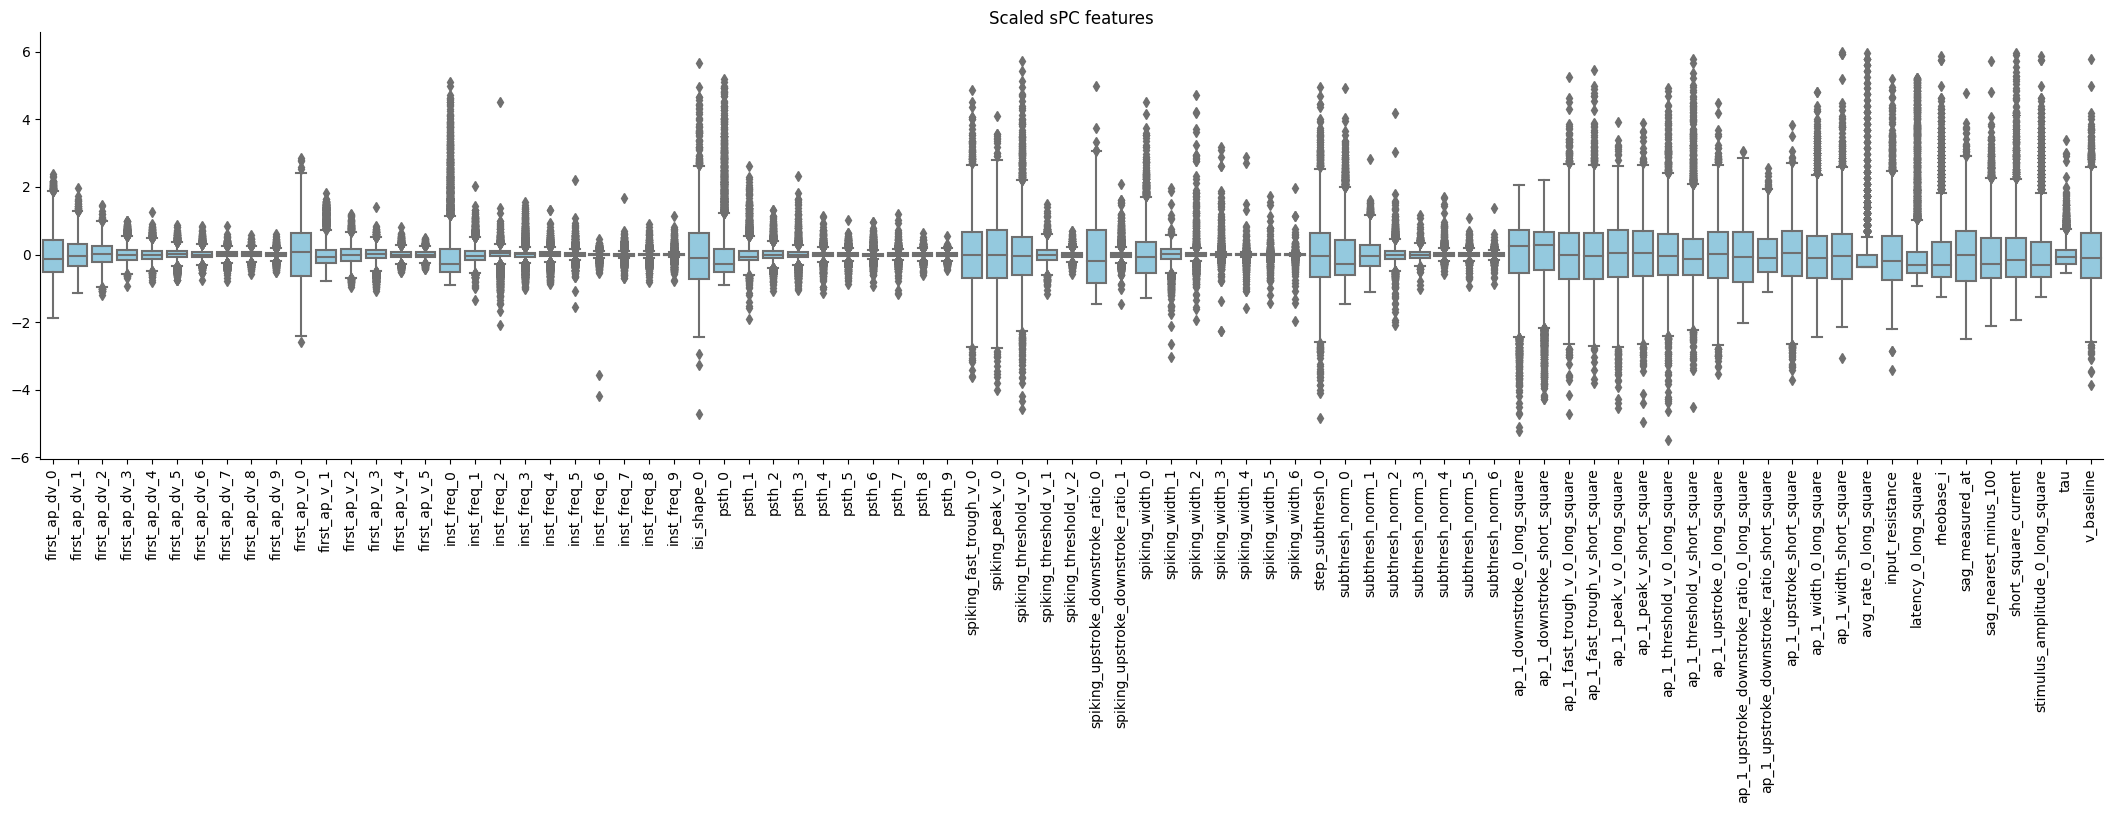

Size of Merged E features: (7158, 84)
Done


In [19]:
print("...................................................")
print("Merging all E features together")

data_frames = [Scaled_PCs, ipfx_norm]
df_merged = reduce(lambda left, right: pd.merge(left, right, on=['specimen_id'], how='inner'), data_frames)
df_merged['specimen_id'] = df_merged['specimen_id'].astype(str)
df_merged = df_merged.merge(pd.DataFrame(specimen_ids, columns=["specimen_id"]), on="specimen_id", how='right')

# Make sure the order is the same as th
df_merged = df_merged.set_index('specimen_id')
df_merged = df_merged.loc[specimen_ids].reset_index()
df_merged.to_csv(pth['e_output'], index=False)

f = df_merged
df = f.melt(value_vars=f[[c for c in f.columns if c != "specimen_id"]])
sns.catplot(x="variable", y="value", kind='box', data=df, palette=sns.color_palette(["skyblue"]), aspect=4.4)
ax = plt.gca()
ax.set(**{'title': 'Scaled sPC features', 'xlabel': '', 'ylabel': ''})
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

print("Size of Merged E features:", df_merged.shape)
print("Done")
